# Imports

In [14]:
import cv2 
import json
import random
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential,load_model
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

# Import dataframe

In [15]:
df = pd.read_pickle('./output/dataCleanColorDef.pkl')
df

,sex,array
0,men,"[[[74, 83, 70], [75, 84, 71], [76, 84, 71], [7..."
1,men,"[[[2, 15, 29], [9, 23, 41], [16, 28, 45], [14,..."
2,men,"[[[128, 128, 0], [128, 128, 0], [128, 128, 0],..."
3,men,"[[[37, 27, 33], [38, 28, 34], [44, 35, 38], [4..."
4,men,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...
3325,women,"[[[157, 164, 174], [158, 167, 176], [158, 170,..."
3326,women,"[[[18, 65, 72], [22, 58, 76], [27, 60, 79], [2..."
3327,women,"[[[29, 33, 43], [20, 25, 35], [24, 29, 39], [1..."
3328,women,"[[[84, 93, 106], [78, 86, 94], [87, 97, 106], ..."


In [16]:
df['sex'] = df['sex'].apply(lambda x: np.where(x == 'men', 0, 1))

In [17]:
X = np.stack(df['array'])
y = np.stack(df['sex'])

In [18]:
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
n_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=n_classes, dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes=n_classes, dtype='float32')

In [20]:
train_X.shape

(2252, 60, 60, 3)

# Sequential model

In [ ]:
model = Sequential()
chanDim = -1

if K.image_data_format() == "channels_first":
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(60,60,3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

# CNN params

EPOCHS = 18
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

#Training the model

model.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])

# Fitting model

In [ ]:
history = model.fit(train_X, y_train,
        batch_size = BS,
        epochs = EPOCHS,
        verbose = 1,
        validation_data = (test_X, y_test))

### Model accuracy

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model loss

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing model

In [ ]:
scores = model.evaluate(test_X, y_test, verbose = 0)

print('Accuracy: %.2f%%' % (scores[1] * 100))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
Y_pred = model.predict(test_X)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1)

In [ ]:
print(Y_pred_classes)
print(Y_true)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save model

In [ ]:
mod = f'model_sequential{(scores[1] * 100)}'
model.save('./output' + mod + '.h5')

In [ ]:
model_json = model.to_json()
with open('./output' + mod + '.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(mod)

# Loading model

In [7]:
with open('./output/model_sequential84.90231037139893.json','r') as f:
    model_json = json.load(f)
    
model = model_from_json(model_json)

model.load_weights('./output/model_sequential84.90231037139893.h5')

### Prediction with test

[0.89482534 0.10517473]
Probs 
man - 0.89483 
woman - 0.10517


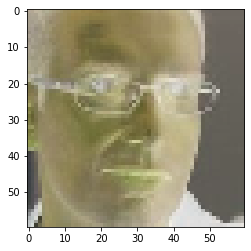

In [22]:
random_indices = [random.randint(0, len(test_X))][0]

img = test_X[random_indices]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
print('Probs \nman - {0:.5f} \nwoman - {1:.5f}'.format(pred[0],pred[1]))

plt.imshow(Image.fromarray(img.squeeze()*255), cmap='gray', interpolation='none')

### Prediction with outside

In [23]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [56]:
def cleanData(img):
    '''
    Reconoce el rostro de personas sobre imágenes:
    - Crea una sección que encuadra el rostro.
    - Transforma la imagen a escala de grises.
    - Reescala la imagen a 48x48.
    - Traduce la información del cuadrante a np.array.
    
    En el caso de no reconocer ningun rostro devuelve /no.
    '''
    try:
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        face_p = faceCascade.detectMultiScale(
            image,
            scaleFactor=1.1,
            minNeighbors=5
        )

        (x, y, w, h) = face_p[0]

        crop_image = image[y:y+h,x:x+w]

        img_data=cv2.resize(crop_image,(60,60))
        
    except Exception as e:
        return e,'no'
    
    return img_data
        

#### Man predict

[0.9977958  0.00220419]
Probs 
man - 0.99780 
woman - 0.00220


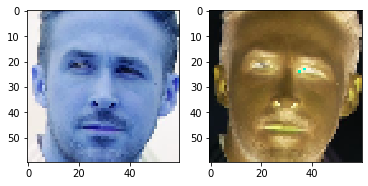

In [60]:
pruf = cleanData('./input/pruf_m.jpg')
input_pruf = cv2.imread('./input/pruf_m.jpg')

plt.subplot(121)
plt.imshow(pruf)
plt.subplot(122)
plt.imshow(Image.fromarray(pruf.squeeze()*255))

pred = model.predict(np.expand_dims(pruf,axis=0))[0]
print(pred)
print('Probs \nman - {0:.5f} \nwoman - {1:.5f}'.format(pred[0],pred[1]))

plt.imshow(Image.fromarray(pruf.squeeze()*255), cmap='gray', interpolation='none')

#### Woman predict

[0.00640309 0.9935969 ]
Probs 
man - 0.00640 
woman - 0.99360


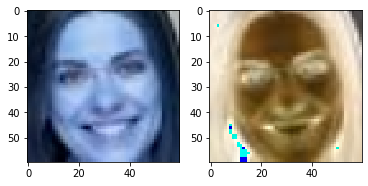

In [61]:
pruf = cleanData('./input/pruf_w.jpeg')
input_pruf = cv2.imread('./input/pruf_w.jpeg')

plt.subplot(121)
plt.imshow(pruf)
plt.subplot(122)
plt.imshow(Image.fromarray(pruf.squeeze()*255))

pred = model.predict(np.expand_dims(pruf,axis=0))[0]
print(pred)
print('Probs \nman - {0:.5f} \nwoman - {1:.5f}'.format(pred[0],pred[1]))

plt.imshow(Image.fromarray(pruf.squeeze()*255), cmap='gray', interpolation='none')